macros latex
$$ 
\def\R{{\mathbb R}} 
\def\x{{\bf x}}
\def\y{{\bf y}}
\def\a{{\bf a}}
$$

In [237]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Régression linéaire : compléments

## Descente de gradient stochastique
*Rappel* : pour une régression linéaire, le gradient de l'EQM s'écrit en fonction des poids $\a \in \R^{d+1}$
$$\nabla_{EQM}(\a) = \frac{2}{m} X^T (X\a-\y)$$
où $X$ est la matrice $(m,d+1)$ de l'échantillon des données et $\y \in \R^m$ le vecteur des étiquettes cibles. Si le nombre de données $m$ est grand, le calcul du gradient en $O(m^2)$ peut s'avérer long (ou soucis de mémoire/temps d'accès aux données). On peut alors utiliser  la technique du *gradient stochastique*.

### descente stochastique
A l'origine, une technique de descente de gradient stochastique signifie faire un pas de gradient dans une direction $d$ aléatoire de sorte que l'espérance de $d$ soit une direction de descente.  
Par exemple, *si l'on tire à une étape au hasard uniformément $i_\omega$ dans $\{1,2,\cdots,m\}$* et que l'on considère l'erreur quadratique par rapport à $x^i$ uniquement 
$$ EQ^i(\a) = (\sum_{j=0}^d a_j x^i_j - y^i)^2 =  (\x^i \cdot \a - \y^i)^2 $$
où $\x^i$ est le vecteur ligne de la $i$-ème donnée
alors $i_\omega$ étant une variable aléatoire on a
$$ E[EQ^{i_\omega}(a)] = \frac{1}{m} \sum_{j=1}^m EQ^j(\a) = EQM(\a) $$

Donc par linéarité en faisant un pas de gradient pour la fonction $EQ^i(m)$ déterminée uniformément au hasard, on fait en moyenne un pas de gradient pour la fonction $EQM(\a)$. Or 
$$\nabla_{EQ^i}(\a) = 2( \x^i \cdot \a - \y^i) (\x^i)^T$$
est simple à calculer.  
Remarquer que
$$ ( \x^i \cdot \a - \y^i) (x^i)^T $$
Consiste à avancer dans la direction de $\x^i$ mutliplié par l'erreur de prédiction.

### descente itérative
En pratique, on ne va pas tirer au hasard $i$ à chaque étape, on va plutôt itérer sur les $i$ de $1$ à $m$ de façon circulaire à chaque pas de gradient. Cette descente s'oppose à la descente déterministe standard où on considère tous les $x^i$, qui est la descente par *batch* (paquet).
SGD : Stochastic Gradient Descent

In [238]:
def descente_gradient_stochastique_RL(X, Y, alpha, a0, max_iter=10000):
    """ Minimise l'EQM par descente de gradient stochastique
    X matrice des données
    y vecteur des cibles
    alpha pas d'apprentissage
    epsilon tolérance
    a0 point initial"""
    a = a0
    k = 0
    points = [a0]
    m = len(X)
    
    #calcul du gradient de EQ^i pour le poids a
    grad = lambda a,i : 2*(X[i,:].dot(a)-Y[i])*(X[i,:].reshape(-1,1))
    
    i = 0
    
    while  k<max_iter:
        a = a - alpha*grad(a,i)
        k +=1
        points.append(a)
        i = (i+1)%m

    return k, points

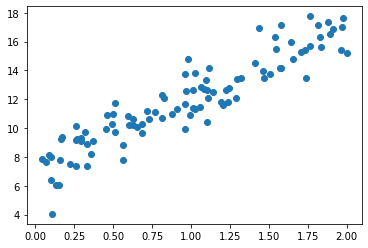

In [239]:
#generations de données sur lesquelles on va faire une descente de gradient stochastique
import matplotlib.pyplot as plt
Xr_plot = 2 * np.random.rand(100, 1)
Yr = 5 * Xr_plot + 7 + np.random.randn(100, 1)
plt.plot(Xr_plot,Yr,'o')
plt.show()

In [240]:
Xr = Xr_plot.reshape(-1,1)
Xra = np.concatenate( (np.ones((len(Xr),1)), Xr), axis=1)  #Xr augmenté−

In [243]:
A01 = np.array([0,0]).reshape(-1,1)
k, points = descente_gradient_stochastique_RL(Xra,Yr,alpha=0.05, a0=A01, max_iter=5000)
#print(k,points[100],points[-1])
a_final = points[-1]
print(a_final)
print(mean_squared_error(Xra.dot(points[-1]),Yr))

[[7.11015141]
 [4.60771613]]
1.4474335718599773


In [242]:
#comparaison des résultats
lin_reg = LinearRegression()
lin_reg.fit(Xr,Yr)
print(lin_reg.intercept_,lin_reg.coef_, )
print(mean_squared_error(lin_reg.predict(Xr),Yr))

[7.15944055] [[4.90759762]]
1.3046276937260304


### Descente par "mini-batchs"
Une méthode intermédiaire consiste à répartir les données en "mini-batchs" (mini-paquets) de taille $k$ fixée. On update alors par le gradient de l'erreur quadratique moyenne sur un mini-paquet fixé. Cette méthode permet d'avoir à la fois une complexité algorithmique raisonnable sur les updates et nécessite un accès aux données moins fréquent.

## Regression polynomiale
Considérons des données situées approximativement sur une courbe de degré 2, par exemple $y=2x^2 - 3x + 5$.

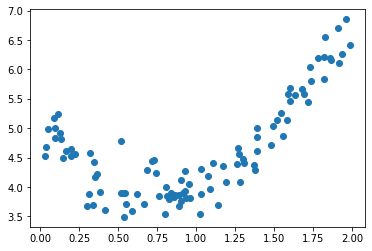

In [246]:
Xq = 2 * np.random.rand(100, 1)
Yq = 2 * Xq**2 - 3*Xq + 5 + 0.3*np.random.randn(100, 1)
plt.plot(Xq,Yq,'o')
plt.show()

Une droite est un mauvais approximateur pour ces données


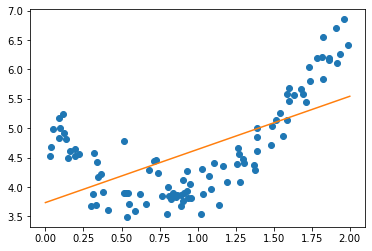

EQM 0.4336786221174224


In [247]:
lin_reg = LinearRegression()
lin_reg.fit(Xq,Yq)
plt.plot(Xq,Yq,'o')
X = np.linspace(0,2,200)
prediction_X = lin_reg.predict(X.reshape(-1,1))
plt.plot(X,prediction_X)
plt.show()
prediction_Xq = lin_reg.predict(Xq.reshape(-1,1))
print("EQM", mean_squared_error(prediction_Xq,Yq))

Pour approcher les données par une courbe quadratique, l'idée est de donner l'accès à la régression linéaire à la valeur de $x^2$ pour chaque donnée $x$. On ajoute à chaque donnée $x^i$ une colonne contenant $(x^i)^2$

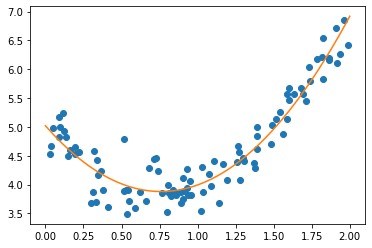

EQM 0.0746276868120812


In [250]:
Xqa = np.concatenate( (Xq, Xq**2), axis=1) #Xadv augmenté
lin_reg.fit(Xqa,Yq)
plt.plot(Xq,Yq,'o')
X = np.linspace(0,2,200).reshape(-1,1)
Xa = np.concatenate( (X, X**2), axis=1)
plt.plot(X,lin_reg.predict(Xa))
plt.show()
prediction_Xq = lin_reg.predict(Xqa)
print("EQM", mean_squared_error(prediction_Xq,Yq))

### Régression quadratique en dimension $d$

En dimension $d$, l'expression totale d'un polynôme quadratique est de la forme 
$$f(x) = \sum_k a_k x_k^2 + \sum_{k \neq \ell} b_{k,\ell} x_k x_\ell + \sum_k c_k x_k + d $$
Il faut transformer les données en associant à la donnée 
$$x=(x_1,x_2,\cdots,x_d)$$ 
la donnée
$$\Phi(x) = (1,x_1,x_2,\cdots,x_d, (x_1)^2, \cdots,(x_d)^2,x_1 \cdot x_2, x_1 \cdot x_3, \dots, x_{d-1} \cdot x_d) $$ 
(on ajoute tous les carrés et les produits de coordonnées).

On opère ensuite une regression linéaire sur $(\Phi(X),Y)$.

## Régression polynomiale en dimension 1

Plus généralement, on peut augmenter les données en ajoutant les puissances nécessaires 
et augmenter ainsi la complexité du modèle (davantage de paramètres = davantage de complexité).

In [191]:
def augmenter_donnees(X, puissance, dim_zero=False):
    Xf = X
    if dim_zero:
        Xf = np.concatenate( (np.ones((len(X),1)), X), axis=1) 
    for i in range(2,puissance+1):
        Xf = np.concatenate( (Xf, X**i), axis=1)
    return Xf

In [192]:
X = np.array([[1,2,3],[4,5,6]])
print(augmenter_donnees(X,3))

[[  1   2   3   1   4   9   1   8  27]
 [  4   5   6  16  25  36  64 125 216]]


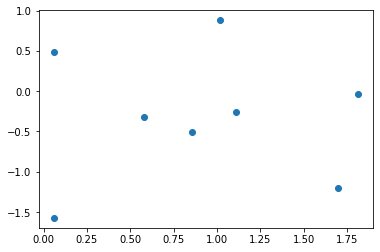

In [286]:
X = 2 * np.random.rand(8, 1)
Y = np.random.randn(8, 1)
plt.plot(X,Y,'o')
plt.show()

In [228]:
def reg_poly_avec_plot(X, Y, k, plot = True):
    """augmente les données X jusqu'à la puissance k -> Xa
    predire Y avec les donnees augmentées Xa (regression de degré k)
    On fait un plot des prédictions obtenues (sur [0;2]) et des
    """
    Xa = augmenter_donnees(X, k)
    lin_reg.fit(Xa,Y)
    Xlin = np.linspace(0,2,200).reshape(-1,1)
    Xlina = augmenter_donnees(Xlin, k)
    #print(lin_reg.predict(Xlina))
    if plot:
        plt.plot(X,Y,'o')
        plt.plot(Xlin, lin_reg.predict(Xlina))
        plt.show()
    prediction_Xa = lin_reg.predict(Xa)
    return mean_squared_error(prediction_Xa,Y)

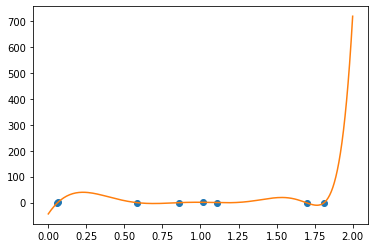

2.169593341605788e-22

In [292]:
reg_poly_avec_plot(X,Y,10)

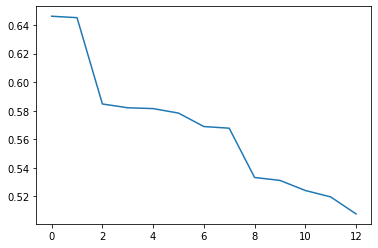

In [284]:
x = [reg_poly_avec_plot(X,Y,i,plot=False) for i in range(2,15)]
plt.plot(x)
plt.show()

On voit apparaître le problème de la **suradaptation** (**overfitting**) aux données d'entraînement.  

Erreur de prédiction = Biais + Variance

Variance : comment varie le modèle quand les données d'entraînement changent (grand si overfitting)

Biais : la qualité d'approximation de vos données par le modèle

modèle : ensemble de fonctions par lequel on approxime les données d'entraînement + algorithme pour le faire

Question : comment trouver le ratio optimal (par la complexité du modèle) entre biais et variance ?

## Exercices

### (prog)
Effectuer une descente de gradient stochastique sur le jeu de données *iris*, et sur le jeu de données *advertising*.
Vérifiez vos résultats avec sklearn.

### (maths & prog)
Programmez et effectuez une descente par mini-batchs pour différentes valeurs de $k$. Comparez les temps de convergence à pas fixé.

### (prog)
Implémentez une régression quadratique pour le jeu de données *advertising*. Compérez l'EQM minimale avec celle obtenue par regression linéaire.